In [319]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Flatten, Dense, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adagrad, RMSprop, Adam, Adadelta, Adamax, Nadam
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
import pydot

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from lifelines.utils import concordance_index

print('TensorFlow', tf.__version__)

TensorFlow 2.2.0


## Data Preprocessing

In [320]:
# Load the data
df = pd.read_csv(r"C:\Users\jeheo\Desktop\School\5.Second Semester\Hands on Machine Learning\HOMLL\data\raw\wpbc_labeled.data", header=1)

In [321]:
# Check the data
df.head()

,Measures,ID_nummer,Outcome,Time,Mean,SE,Worst,Mean.1,SE.1,Worst.1,...,SE.7,Worst.7,Mean.8,SE.8,Worst.8,Mean.9,SE.9,Worst.9,Tum_Size,Lymp_stat
0,0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,...,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5
1,1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2
2,2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,...,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0
3,3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0
4,4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0


In [322]:
## Preprocessing the data
def to_censored(Outcome):
    """
    The data has N and R as non-reccurent and reccurent.
    Threfore, we have to change that as integer, 1, 0
    """
    Outcome = str(Outcome)
    if Outcome == "N":
        return 0.0
    else:
        return 1.0
    
df["Censored"] = df["Outcome"].apply(to_censored)

In [323]:
# select the cols of data as X and Y
Y = df.loc[:,["Censored","Time"]]
X = df.drop(["Time", "Censored", "Outcome","ID_nummer", "Measures"], axis=1)

In [324]:
X.dtypes

Mean         float64
SE           float64
Worst        float64
Mean.1       float64
SE.1         float64
Worst.1      float64
Mean.2       float64
SE.2         float64
Worst.2      float64
Mean.3       float64
SE.3         float64
Worst.3      float64
Mean.4       float64
SE.4         float64
Worst.4      float64
Mean.5       float64
SE.5         float64
Worst.5      float64
Mean.6       float64
SE.6         float64
Worst.6      float64
Mean.7       float64
SE.7         float64
Worst.7      float64
Mean.8       float64
SE.8         float64
Worst.8      float64
Mean.9       float64
SE.9         float64
Worst.9      float64
Tum_Size     float64
Lymp_stat     object
dtype: object

In [325]:
X["Lymp_stat"].mode() 

0    0
dtype: object

In [326]:
# I checked the data and found out "?" is problem
j = 0
for i in X["Lymp_stat"]:
    if i == "?":
        print(j)
    j += 1

6
28
85
196


In [327]:
# replace "?" to "0" for further process
X["Lymp_stat"].replace({"?": "0"}, inplace=True)

In [328]:
# check the results
j = 0
for i in X["Lymp_stat"]:
    if i == "?":
        print(j)
    j += 1

In [329]:
# Change data type from list to array
X = np.array(X.values)

In [330]:
# Standardization before the neural nets because we assume we don't know which is important features.

scaler = StandardScaler()
scaler.fit(X)
X=scaler.transform(X)

In [331]:
# split the data X and Y into train set, test set and yousing stratified.

random_state = 10

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.2, random_state=random_state, stratify=Y["Censored"])

In [332]:
# Check the shape of the data
X_train.shape, X_test.shape

((158, 32), (40, 32))

In [333]:
Y_train.shape, Y_test.shape

((158, 2), (40, 2))

In [334]:
Y_train = Y_train.values
Y_test = Y_test.values

In [335]:
# reshape the input and the output

x_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
x_test = X_test.reshape(X_test.shape[0], X_test.shape[1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1])
y_test = Y_test.reshape(Y_test.shape[0], Y_test.shape[1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [336]:
x_train.shape
input_shape = (32)

In [337]:
x_train.shape

(158, 32)

In [341]:
y_train.dtype

dtype('float32')

## Build a model

In [74]:
model = Sequential()

In [102]:
def negative_log_likelih_cox(yTrue,yPred):
    yStatus = yTrue[:,0]
    yTime = yTrue[:,1]
    """
      deep learning version of the cox-proportional hazards marginal log-likelihood for tensorflow

      Ref: Katzman, J., Shaham, U., Bates, J., Cloninger, A., Jiang, T., Kluger, Y., 2018. 
      DeepSurv: Personalized Treatment Recommender System Using A Cox Proportional Hazards 
      Deep Neural Network. BMC Medical Research Methodology 18. https://doi.org/10.1186/s12874-018-0482-1

      see also https://keras.io/api/losses/#creating-custom-losses
    """
    # custom loss function: 
    # partial negative log likelihood of the cox proportional harzards model

    def fun_logsumexp(i, yPred, yTime):
        j_mask = tf.greater_equal(yTime,i)
        yPred_masked = tf.boolean_mask(yPred,j_mask)
        logsumexp_ = tf.reduce_logsumexp(yPred_masked) # reduce_logsumexp?
        return logsumexp_
    
    logsumexp = tf.map_fn(lambda i: fun_logsumexp(i,yPred,yTime), yTime) 
    
    # each tensor is 1D with shape (n,)
    # after expand dim it's (n,1)
    # after concatenation it's (n,3)
    # -> enable usage tf.map_fn for computations along the n's
    yStatus = tf.expand_dims(yStatus,1)
    logsumexp = tf.expand_dims(logsumexp,1)
    d_theta_nls = tf.concat([yStatus, yPred, logsumexp], axis=1)
    
    def fun_loglikelihood_i(x):
        loss_i = x[0] * (x[1] - x[2]) # = d_i * (theta_i - logsumexp_i)
        return loss_i
    
    log_likelih_summands = tf.map_fn(lambda x: fun_loglikelihood_i(x), d_theta_nls)
    loss = -tf.reduce_mean(log_likelih_summands)    
    return loss

In [103]:
model = Sequential()

# input layers
model.add(tf.keras.layers.Input(shape = input_shape, name = 'input'))

# hidden layers
model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h1", activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h2", activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))
model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h3", activity_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

#out_put layers
model.add(tf.keras.layers.Dense(1, kernel_initializer='lecun_normal', name="out_put"))

#compile the layers
model.compile(loss=negative_log_likelih_cox, optimizer=Nadam(learning_rate=0.001))

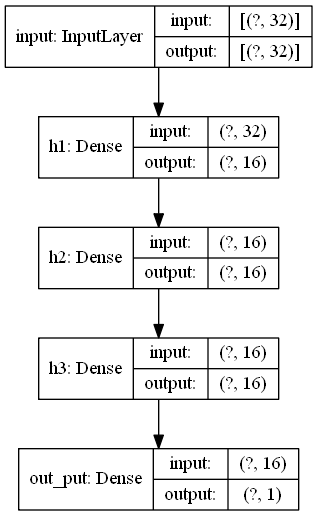

In [104]:
# it shows how the model looks like
tf.keras.utils.plot_model(model, show_shapes=True)

In [105]:
# Now check the model

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)
history = model.fit(x_train, y_train,
          validation_split=0.2, shuffle=True
        ,epochs=2, callbacks=[callback])

Epoch 1/2
4/4 [==============================] - 0s 73ms/step - loss: 0.7273 - val_loss: 0.8650
Epoch 2/2
4/4 [==============================] - 0s 15ms/step - loss: 0.7041 - val_loss: 0.8383


## Grid Search for l1_l2 and learning rate.

In [122]:
# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, l1=1e-5, l2=1e-4):
    model = Sequential()

    # input layers
    model.add(tf.keras.layers.Input(shape = input_shape, name = 'input'))

    # hidden layers
    model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h1", activity_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h2", activity_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))
    model.add(tf.keras.layers.Dense(16, kernel_initializer='lecun_normal', activation='selu', name="h3", activity_regularizer=regularizers.l1_l2(l1=l1, l2=l2)))

    #out_put layers
    model.add(tf.keras.layers.Dense(1, kernel_initializer='lecun_normal', name="out_put"))

    #compile the layers
    model.compile(loss=negative_log_likelih_cox, optimizer=Nadam(learning_rate=0.001), metrics=["accuracy"])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
l1 = [1e-6, 1e-5, 1e-4]
l2 = [1e-5, 1e-4, 1e-3]

cindex = concordance_index(Y_val['time'], -model.predict(X_val), Y_val['status'])

param_grid = dict(learn_rate=learn_rate, l1=l1, l2=l2)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.351613 using {'l1': 0.0001, 'l2': 0.0001, 'learn_rate': 0.01}
0.326613 (0.058870) with: {'l1': 1e-06, 'l2': 1e-05, 'learn_rate': 0.001}
0.333065 (0.082818) with: {'l1': 1e-06, 'l2': 1e-05, 'learn_rate': 0.01}
0.320262 (0.053172) with: {'l1': 1e-06, 'l2': 1e-05, 'learn_rate': 0.1}
0.301109 (0.062693) with: {'l1': 1e-06, 'l2': 1e-05, 'learn_rate': 0.2}
0.304637 (0.061421) with: {'l1': 1e-06, 'l2': 1e-05, 'learn_rate': 0.3}
0.335786 (0.046365) with: {'l1': 1e-06, 'l2': 0.0001, 'learn_rate': 0.001}
0.326411 (0.046440) with: {'l1': 1e-06, 'l2': 0.0001, 'learn_rate': 0.01}
0.335887 (0.055607) with: {'l1': 1e-06, 'l2': 0.0001, 'learn_rate': 0.1}
0.323185 (0.060727) with: {'l1': 1e-06, 'l2': 0.0001, 'learn_rate': 0.2}
0.316532 (0.011333) with: {'l1': 1e-06, 'l2': 0.0001, 'learn_rate': 0.3}
0.313609 (0.049755) with: {'l1': 1e-06, 'l2': 0.001, 'learn_rate': 0.001}
0.336492 (0.091076) with: {'l1': 1e-06, 'l2': 0.001, 'learn_rate': 0.01}
0.326613 (0.067129) with: {'l1': 1e-06, 'l2': 0.001,

# Train the model with the best hyperparameter

In [296]:
best_model= create_model(learn_rate=0.01, l1=1e-4, l2=1e-4)
best_model.fit(x_train, y_train,
         validation_split=0.2, shuffle=True
        ,epochs=100, callbacks= callback)

Epoch 1/100
4/4 [==============================] - 0s 69ms/step - loss: 0.6916 - accuracy: 0.3730 - val_loss: 0.8349 - val_accuracy: 0.3281
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6747 - accuracy: 0.3690 - val_loss: 0.8263 - val_accuracy: 0.3281
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6569 - accuracy: 0.3810 - val_loss: 0.8196 - val_accuracy: 0.3438
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6614 - accuracy: 0.3849 - val_loss: 0.8111 - val_accuracy: 0.3594
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6511 - accuracy: 0.3849 - val_loss: 0.8057 - val_accuracy: 0.3750
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.6470 - accuracy: 0.3810 - val_loss: 0.7984 - val_accuracy: 0.3906
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.6319 - accuracy: 0.3810 - val_loss: 0.7965 - val_accuracy: 0.3906
Epoch 8/100
4/4 [===

## Cindex Calculation

In [297]:
y_test = pd.DataFrame(y_test, columns=["status", "time"])

In [298]:
cindex = concordance_index(y_test['time'], -best_model.predict(x_test), y_test['status'])

In [305]:
cindex_rsf = 0.680751
cindex_cox = 0.769953
cindex_neu = 0.708920

cindex = {"Cindex":[cindex_rsf, cindex_cox, cindex_neu], 
          "Validation error": [0.6103,0.6320,0.7996], 
          "Train score":[0.9489, 0.6687,0.5738]}

## Final report

In [306]:
report = pd.DataFrame(cindex, index=["RSF", "Cox Regression", "Neural Net"])

In [307]:
report

,Cindex,Validation error,Train score
RSF,0.680751,0.6103,0.9489
Cox Regression,0.769953,0.6320,0.6687
Neural Net,0.708920,0.7996,0.5738


> Breifly, the RSF is pretty much overfitting and the shortage of the data causes the most simple methods take the winner position, Cox Regression

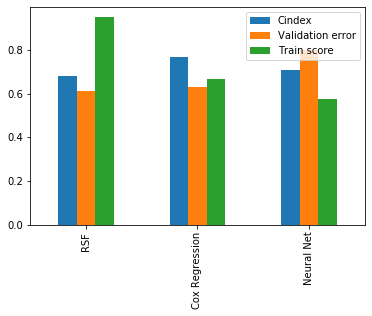

In [318]:
report.plot.bar()
plt.show()